In [1]:
import torch
import torch.nn as nn
import torchvision
#import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Dataset
import torch,gzip,os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [4]:
class DealDataset(Dataset):
    """
        读取数据、初始化数据
    """
    def __init__(self, folder, data_name, label_name,transform=None):
        (train_set, train_labels) = load_data(folder, data_name, label_name) # 其实也可以直接使用torch.load(),读取之后的结果为torch.Tensor形式
        self.train_set = train_set
        self.train_labels = train_labels
        self.transform = transform

    def __getitem__(self, index):

        img, target = self.train_set[index], int(self.train_labels[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.train_set)

In [5]:
def load_data(data_folder, data_name, label_name):
    """
        data_folder: 文件目录
        data_name： 数据文件名
        label_name：标签数据文件名
    """
    with gzip.open(os.path.join(data_folder,label_name), 'rb') as lbpath: # rb表示的是读取二进制数据
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(os.path.join(data_folder,data_name), 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
    return (x_train, y_train)


In [7]:
train_dataset = DealDataset('E:\\mnist\\', "train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz",transform=transforms.ToTensor())
test_dataset = DealDataset('E:\\mnist\\', "t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz",transform=transforms.ToTensor())

In [8]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [9]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        # super函数用来解决多重继承时父类的查找问题
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [10]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [12]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

C:\ProgramData\Anaconda3\envs\OpenCv\lib\site-packages\torchvision\transforms\functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch [1/5], Step [100/600], Loss: 0.3203
Epoch [1/5], Step [200/600], Loss: 0.1984
Epoch [1/5], Step [300/600], Loss: 0.3221
Epoch [1/5], Step [400/600], Loss: 0.1702
Epoch [1/5], Step [500/600], Loss: 0.1167
Epoch [1/5], Step [600/600], Loss: 0.0587
Epoch [2/5], Step [100/600], Loss: 0.1382
Epoch [2/5], Step [200/600], Loss: 0.0391
Epoch [2/5], Step [300/600], Loss: 0.0782
Epoch [2/5], Step [400/600], Loss: 0.0726
Epoch [2/5], Step [500/600], Loss: 0.0302
Epoch [2/5], Step [600/600], Loss: 0.1660
Epoch [3/5], Step [100/600], Loss: 0.0424
Epoch [3/5], Step [200/600], Loss: 0.0732
Epoch [3/5], Step [300/600], Loss: 0.0881
Epoch [3/5], Step [400/600], Loss: 0.0936
Epoch [3/5], Step [500/600], Loss: 0.0275
Epoch [3/5], Step [600/600], Loss: 0.0881
Epoch [4/5], Step [100/600], Loss: 0.0380
Epoch [4/5], Step [200/600], Loss: 0.0667
Epoch [4/5], Step [300/600], Loss: 0.0465
Epoch [4/5], Step [400/600], Loss: 0.0153
Epoch [4/5], Step [500/600], Loss: 0.0405
Epoch [4/5], Step [600/600], Loss:

In [13]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 97.5 %


In [14]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [5/60], Loss: 0.9400
Epoch [10/60], Loss: 0.6308
Epoch [15/60], Loss: 0.5052
Epoch [20/60], Loss: 0.4539
Epoch [25/60], Loss: 0.4327
Epoch [30/60], Loss: 0.4238
Epoch [35/60], Loss: 0.4198
Epoch [40/60], Loss: 0.4178
Epoch [45/60], Loss: 0.4166
Epoch [50/60], Loss: 0.4157
Epoch [55/60], Loss: 0.4150
Epoch [60/60], Loss: 0.4143


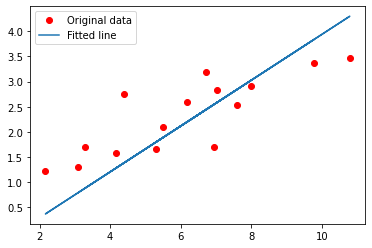

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# Hyper-parameters
input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

# Toy dataset
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

# Linear regression model
# 全连接层
model = nn.Linear(input_size, output_size)

# Loss and optimizer
# 损失函数和激活函数
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# 训练模型
# Train the model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Plot the graph
predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')